In [41]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import LeaveOneGroupOut, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# feature engineering

In [3]:
df = pd.read_csv('./DogMoveDataExtracted.csv')

In [4]:
# sum of triaxial SD for each sensor modality 
df['Axyz_SD'] = (df['Ax_Standard deviation'] + df['Ay_Standard deviation'] + df['Ax_Standard deviation'])
df['Gxyz_SD'] = (df['Gx_Standard deviation'] + df['Gy_Standard deviation'] + df['Gx_Standard deviation'])

# mean value (3 axes, 2 sensor modalities = 6 total)
# already included in dataframe (one of the default features to be extracted by tsfel)

# sum of triaxial zero crossing rate for each sensor modality
df['Axyz_ZCR'] = df['Ax_Zero crossing rate'] + df['Ay_Zero crossing rate'] + df['Az_Zero crossing rate']
df['Gxyz_ZCR'] = df['Gx_Zero crossing rate'] + df['Gy_Zero crossing rate'] + df['Gz_Zero crossing rate']

In [5]:
df.iloc[114:118, -8:-6] # labels have some values between 0 and 1 where there was a transition of behavior, as shown here 

,Behavior_Moving_Mean,Behavior_Sitting_Mean
114,1.00,0.00
115,0.81,0.19
116,0.31,0.69
117,0.00,1.00


In [6]:
for col in ['Behavior_Lying_Mean', 'Behavior_Moving_Mean', 'Behavior_Sitting_Mean', 'Behavior_Standing_Mean']:
    df[col] = np.where(df[col] >= 0.5, 1, 0) # replace values >= 0.5 with 1, else 0 

In [7]:
df.iloc[114:118, -8:-6] # confirm that the change has been made 

,Behavior_Moving_Mean,Behavior_Sitting_Mean
114,1,0
115,1,0
116,0,1
117,0,1


In [8]:
# position offset: euclidean distance from robust mean (standing) - recalculate for each dogID
# groupby DogID_Mean
# where Behavior_Standing_Mean == 1
# take 'robust mean' of standing dog 
# euclidian distance from observation to mean of standing 

df.groupby('DogID_Mean') 
mean_standing = df.iloc[np.where(df['Behavior_Standing_Mean'] == 1)] # select only rows where dog is standing 
mean_standing = mean_standing.iloc[:,[7,17,27,37,47,57,-5]] # select only gyro and acc columns + dog ID 
height = pd.DataFrame() # height is the robust mean of standing for A and G  

dict = np.unique(mean_standing['DogID_Mean']) # unique dog IDs
dict2 = np.unique(df['DogID_Mean']) # unique dog IDs
print(len(dict), len(dict2),'\n', dict2) # found a dog that never stood up! 


# compare filtered dataset to unmodified dataset to work out how many dogs are missing 
# take one value from the other to get the number of missing entries (n)
# assign (n) new values to dataset and impute mean values 

for x in dict: # iterate over individual dogs 
    temp = mean_standing.iloc[np.where(mean_standing['DogID_Mean'] == x)] # temp df where DogID == dog (x) 
    avg = temp.mean() # take mean of standing for that dog 
    height = height.append({'DogID':x,'Axyz_Mean_Standing':[avg[0],avg[1], avg[2]], 'Gxyz_Mean_Standing':[avg[3], avg[4], avg[5]]}, ignore_index=True) # add mean of standing for each dog to a new df

height = height.append({'DogID':58.0,'Axyz_Mean_Standing':[0.1,0.1,0.1], 'Gxyz_Mean_Standing':[0.1,0.1,0.1]}, ignore_index=True) 
# impute Axyz & Gxyz values for missing dog 

44 45 
 [16. 18. 19. 20. 21. 22. 23. 25. 26. 27. 28. 29. 30. 33. 34. 36. 39. 41.
 43. 44. 45. 46. 47. 48. 49. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61.
 63. 65. 66. 67. 68. 70. 72. 73. 74.]


In [9]:
appendL = []
def eucildean_calculator(df, i, j): 
    heightTable = (height.loc[height["DogID"] == float(df[-5])]) # match dogIDs
    A = heightTable["Axyz_Mean_Standing"] 
    G = heightTable["Gxyz_Mean_Standing"]
    windowA = np.array(df[i]) # create array of sensor axis values 
    windowG = np.array(df[j])   
    retA = np.linalg.norm(np.array(A)[0] - windowA) # calculate position offset (euclidean distance from mean of standing)
    retG = np.linalg.norm(np.array(G)[0] - windowG) 
    appendL.append([retA, retG]) # append position offset values to empty list 

out = np.apply_along_axis(eucildean_calculator, 1, df, [7,17,27], [37,47,57]) # apply function along axis. [7,17,27], [37,47,57] indicate columns from which to create window vector 
appendL = pd.DataFrame(appendL, columns=["APO", "GPO"]) # APO = Acc. pos ofset
df = pd.concat([df, appendL], axis=1) # aggregate pos ofset values to main dataframe
df.head()

,Ax_ECDF Percentile_0,Ax_ECDF Percentile_1,Ax_ECDF Percentile_2,Ax_ECDF Percentile_3,Ax_ECDF Percentile_4,Ax_ECDF Percentile_5,Ax_ECDF Percentile_6,Ax_Mean,Ax_Standard deviation,Ax_Zero crossing rate,Ay_ECDF Percentile_0,Ay_ECDF Percentile_1,Ay_ECDF Percentile_2,Ay_ECDF Percentile_3,Ay_ECDF Percentile_4,Ay_ECDF Percentile_5,Ay_ECDF Percentile_6,Ay_Mean,Ay_Standard deviation,Ay_Zero crossing rate,Az_ECDF Percentile_0,Az_ECDF Percentile_1,Az_ECDF Percentile_2,Az_ECDF Percentile_3,Az_ECDF Percentile_4,Az_ECDF Percentile_5,Az_ECDF Percentile_6,Az_Mean,Az_Standard deviation,Az_Zero crossing rate,Gx_ECDF Percentile_0,Gx_ECDF Percentile_1,Gx_ECDF Percentile_2,Gx_ECDF Percentile_3,Gx_ECDF Percentile_4,Gx_ECDF Percentile_5,Gx_ECDF Percentile_6,Gx_Mean,Gx_Standard deviation,Gx_Zero crossing rate,Gy_ECDF Percentile_0,Gy_ECDF Percentile_1,Gy_ECDF Percentile_2,Gy_ECDF Percentile_3,Gy_ECDF Percentile_4,Gy_ECDF Percentile_5,Gy_ECDF Percentile_6,Gy_Mean,Gy_Standard deviation,Gy_Zero crossing rate,Gz_ECDF Percentile_0,Gz_ECDF Percentile_1,Gz_ECDF Percentile_2,Gz_ECDF Percentile_3,Gz_ECDF Percentile_4,Gz_ECDF Percentile_5,Gz_ECDF Percentile_6,Gz_Mean,Gz_Standard deviation,Gz_Zero crossing rate,Behavior_Lying_Mean,Behavior_Moving_Mean,Behavior_Sitting_Mean,Behavior_Standing_Mean,DogID_Mean,Axyz_SD,Gxyz_SD,Axyz_ZCR,Gxyz_ZCR,APO,GPO
0,-0.143066,-0.022461,0.080566,0.145996,0.228027,0.292969,0.458496,0.150505,0.272173,15.0,-0.080078,0.009277,0.083496,0.121094,0.185059,0.248047,0.362793,0.151338,0.222240,24.0,0.743652,0.797852,0.837402,0.909668,1.002441,1.098145,1.166992,0.942500,0.182289,0.0,-28.747560,-18.798829,-11.169434,-3.906250,3.051758,9.887696,18.249513,-3.989258,22.366513,26.0,-75.500493,-41.442874,-14.099122,5.615235,26.611330,42.419436,57.678226,-1.152344,53.702158,22.0,-85.876470,-51.696780,-25.878908,31.188967,59.387211,78.552251,91.735845,12.845765,73.371791,7.0,0,1,0,0,16.0,0.766586,98.435184,39.0,55.0,0.258720,12.933980
1,-0.240234,-0.057617,0.047852,0.135254,0.223633,0.305176,0.585449,0.235457,1.521563,17.0,-0.102539,0.007813,0.063477,0.107910,0.187988,0.258789,0.426758,0.141038,0.299801,28.0,0.528320,0.727051,0.795898,0.876465,0.956543,1.068848,1.192383,0.600957,1.095543,3.0,-35.278322,-23.071290,-15.258790,-5.310059,2.868653,11.291505,28.686525,3.672180,49.716805,23.0,-80.810552,-41.381838,-13.488770,11.169434,36.682131,52.062991,71.716313,-0.671997,355.114240,22.0,-92.041021,-69.335942,-38.024905,18.859864,42.480471,76.171880,93.322760,5.334778,83.761459,10.0,0,1,0,0,16.0,3.342927,454.547851,48.0,55.0,0.312724,6.280836
2,-4.384277,-0.348145,-0.023438,0.162109,0.504395,2.643555,7.248535,0.751301,5.305160,20.0,-1.432617,-0.395996,-0.047363,0.045410,0.159668,0.291992,0.968262,-0.168330,1.283947,38.0,-5.763672,-4.580078,-3.578125,-2.059570,0.637207,0.836426,1.164063,-2.018865,2.984131,13.0,-41.503909,-23.315431,-4.760742,16.540528,95.275885,168.090831,315.856953,90.644842,208.561333,24.0,-1473.877043,-823.974660,-46.142581,3.662110,57.006839,541.198764,1384.887780,-30.523989,1028.757185,22.0,-244.628921,-115.356452,-65.856938,-12.329102,66.406254,120.483406,246.948257,0.733643,227.020670,18.0,0,1,0,0,16.0,11.894268,1445.879850,71.0,64.0,2.923575,95.953764
3,-6.052734,-2.582520,-0.201660,0.225586,0.881836,4.084961,7.791992,0.574026,6.160287,23.0,-2.360840,-1.245605,-0.578613,-0.059570,0.205078,0.550781,1.342285,-0.385298,1.611561,37.0,-5.896484,-4.989746,-3.798340,-3.117188,-1.792480,0.210938,1.014648,-2.651589,2.813742,21.0,-126.892098,-26.245119,19.226075,42.358401,119.201667,213.500990,336.853048,95.704657,243.888270,30.0,-1523.742769,-1048.645084,-236.206069,-8.117676,279.602068,1068.542546,1462.341398,3.024903,1148.386039,23.0,-342.468283,-216.857923,-57.861332,26.733400,104.980475,192.749035,370.239280,11.861878,293.007744,25.0,0,1,0,0,16.0,13.932136,1636.162580,81.0,78.0,3.561096,96.697896
4,-1.507324,-0.171875,0.030591,0.160645,0.269043,0.431680,0.729492,0.071387,3.456329,23.0,-0.957520,-0.067095,0.067559,0.178711,0.248599,0.3

In [10]:
# drop axis SD features since we have already calculated their sum with Axyz_SD and Gxyz_SD
# also drop axis ZCR since we have calculated their sum also 
df.drop(columns=['Ax_Standard deviation', 'Ay_Standard deviation', 'Az_Standard deviation', 'Gx_Standard deviation', 'Gy_Standard deviation', 'Gz_Standard deviation',
'Ax_Zero crossing rate', 'Ay_Zero crossing rate', 'Az_Zero crossing rate', 'Gx_Zero crossing rate', 'Gy_Zero crossing rate', 'Gz_Zero crossing rate'], inplace=True)

# exploring the data with some plots

In [11]:
# reverse dummy encoding behavior labels for plotting purposes. then rename 
df['Behavior'] = (df.iloc[:, -11:-6] == 1).idxmax(1)
df['Behavior'].replace({'Behavior_Moving_Mean':'Moving', 'Behavior_Lying_Mean':'Lying', 'Behavior_Sitting_Mean':'Sitting', 'Behavior_Standing_Mean':'Standing'}, inplace=True)

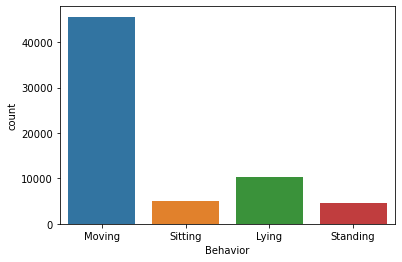

In [12]:
sns.countplot(x='Behavior', data=df)
plt.show()
# class imbalance is clear ! many more moving samples than static 

<AxesSubplot:xlabel='Behavior', ylabel='Gxyz_SD'>

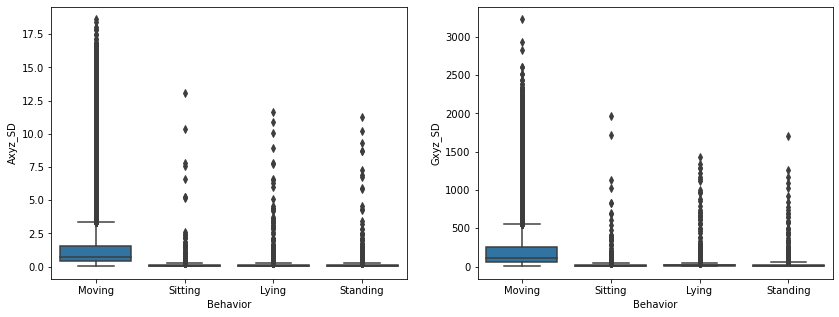

In [13]:
# plot total activity (sum SD) by behavior 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(14, 5)
sns.boxplot(x='Behavior', y="Axyz_SD", data=df, ax=ax[0])
sns.boxplot(x='Behavior', y="Gxyz_SD", data=df, ax=ax[1])

# dynamic behavior associated with a greater range in total activity (sum SD), as one might expect 

<AxesSubplot:xlabel='Behavior', ylabel='Gxyz_ZCR'>

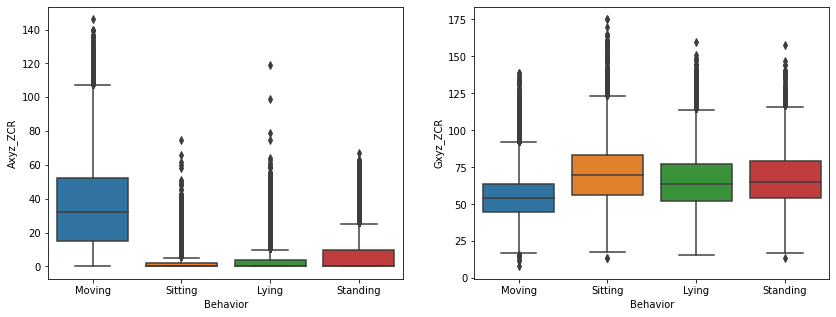

In [14]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(14, 5)
sns.boxplot(x='Behavior', y="Axyz_ZCR", data=df, ax=ax[0])
sns.boxplot(x='Behavior', y="Gxyz_ZCR", data=df, ax=ax[1])

# appears that sum(ZCR) from accelerometer doesnt tell the same story as sum(ZCR) from gyroscope! 


<AxesSubplot:xlabel='Behavior', ylabel='GPO'>

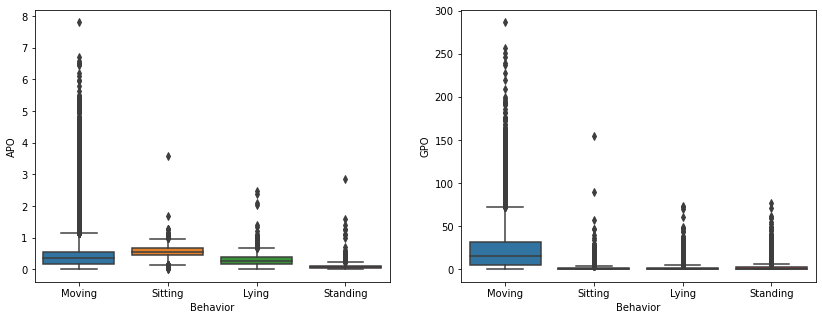

In [15]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(14, 5)
sns.boxplot(x='Behavior', y="APO", data=df, ax=ax[0])
sns.boxplot(x='Behavior', y="GPO", data=df, ax=ax[1])

# similarly, acc & gyro position offset seems to have a wider and slightly higher range for dynamic behavior than static 

In [16]:
# before we move onto feature selection, we can remove any rows where behaviour = Standing. This label was included up to this point to enable to calculation of a mean of standing for each dog, which was a prerequsite for the calculation of the feature position offset (APO, GPO) 
# now that APO & GPO have been calculated and added to the dataframe, we can drop behavior=Standing rows 

df = df[~df['Behavior'].isin(['Standing'])] # drop rows where behavior == standing 

# feature selection
* univariate selection with ANOVA (f_classif)
* ExtraTreesClassifier 

In [17]:
# cols = list(df.columns.values) # rearrange column order to make slicing easier 
df = df[['Ax_ECDF Percentile_0', 'Ax_ECDF Percentile_1', 'Ax_ECDF Percentile_2', 'Ax_ECDF Percentile_3', 'Ax_ECDF Percentile_4', 'Ax_ECDF Percentile_5', 'Ax_ECDF Percentile_6', 'Ax_Mean', 'Ay_ECDF Percentile_0', 'Ay_ECDF Percentile_1', 'Ay_ECDF Percentile_2', 'Ay_ECDF Percentile_3', 'Ay_ECDF Percentile_4', 'Ay_ECDF Percentile_5', 'Ay_ECDF Percentile_6', 'Ay_Mean', 'Az_ECDF Percentile_0', 'Az_ECDF Percentile_1', 'Az_ECDF Percentile_2', 'Az_ECDF Percentile_3', 'Az_ECDF Percentile_4', 'Az_ECDF Percentile_5', 'Az_ECDF Percentile_6', 'Az_Mean', 'Gx_ECDF Percentile_0', 'Gx_ECDF Percentile_1', 'Gx_ECDF Percentile_2', 'Gx_ECDF Percentile_3', 'Gx_ECDF Percentile_4', 'Gx_ECDF Percentile_5', 'Gx_ECDF Percentile_6', 'Gx_Mean', 'Gy_ECDF Percentile_0', 'Gy_ECDF Percentile_1', 'Gy_ECDF Percentile_2', 'Gy_ECDF Percentile_3', 'Gy_ECDF Percentile_4', 'Gy_ECDF Percentile_5', 'Gy_ECDF Percentile_6', 'Gy_Mean', 'Gz_ECDF Percentile_0', 'Gz_ECDF Percentile_1', 'Gz_ECDF Percentile_2', 'Gz_ECDF Percentile_3', 'Gz_ECDF Percentile_4', 'Gz_ECDF Percentile_5', 'Gz_ECDF Percentile_6', 'Gz_Mean', 'Axyz_SD', 'Gxyz_SD', 'Axyz_ZCR', 'Gxyz_ZCR', 'APO', 'GPO', 'Behavior_Lying_Mean', 'Behavior_Moving_Mean', 'Behavior_Sitting_Mean', 'Behavior_Standing_Mean', 'DogID_Mean', 'Behavior']]

# dummy encoded behaviour labels were needed for feature extraction but not for classification. hence we can drop them 
df.drop(columns=['Behavior_Lying_Mean', 'Behavior_Moving_Mean', 'Behavior_Sitting_Mean', 'Behavior_Standing_Mean'], inplace=True)

In [18]:
y = df['Behavior']
x = df.iloc[:,:-2]

skb_model = SelectKBest(f_classif, k=14) # anova feature selection - modify k here 
skb_model.fit(x, y)

features = skb_model.fit_transform(x,y) # identify k best features 
skb_top_n_features_ind = skb_model.get_support(indices=True) # index these features 
fsel = x.iloc[:,skb_top_n_features_ind] 

features_ranked = pd.DataFrame({'col_name': skb_model.scores_}, index=x.columns).sort_values(by='col_name', ascending=False)

skb_top_n_features_ind


array([10, 11, 12, 13, 14, 15, 21, 22, 40, 41, 45, 46, 50, 53])

<AxesSubplot:title={'center':'ranked feature importance scores from SelectKBest ANOVA test'}>

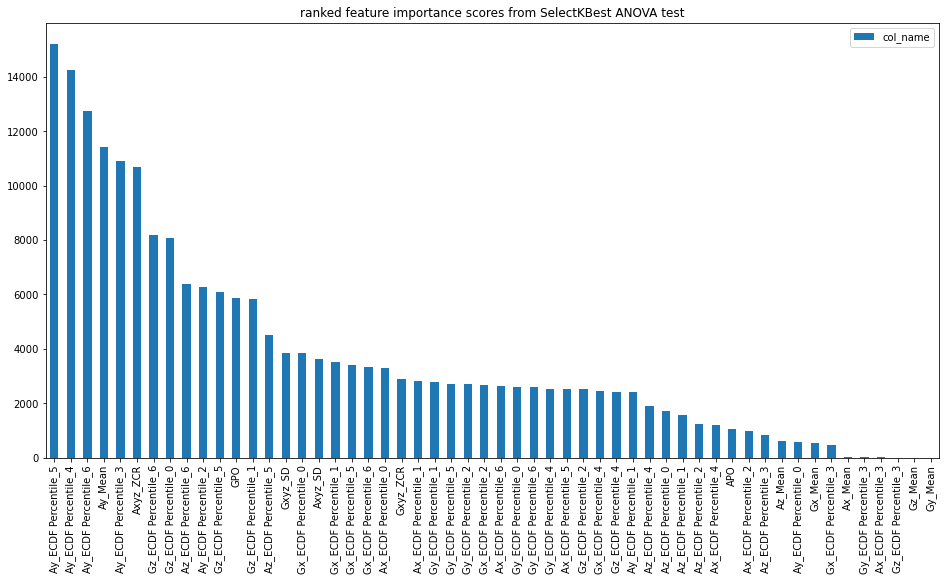

In [19]:
features_ranked.plot(kind='bar', figsize=(16,8), title='ranked feature importance scores from SelectKBest ANOVA test')
# diminishing returns after k=14 

In [20]:
y = df['Behavior']
x = df.iloc[:,:-2]

# feature selection with extra trees classifier 
etc_model = ExtraTreesClassifier(n_estimators=100)
etc_model.fit(x, y)

features_ranked = pd.DataFrame({'col_name': etc_model.feature_importances_}, index=x.columns).sort_values(by='col_name', ascending=False)

etc_top_n_features = features_ranked.iloc[:9,:] # modify n here 
cols = list(etc_top_n_features.index.values) 
etc_top_n_features_ind = [df.columns.get_loc(c) for c in cols if c in df]

<AxesSubplot:title={'center':'ranked feature importance scores from ExtraTreesClassifier'}>

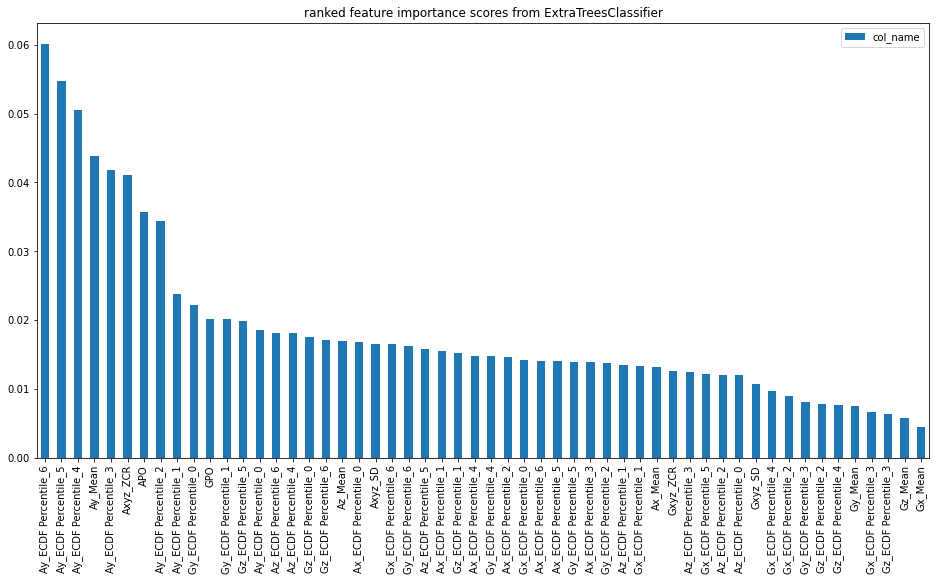

In [21]:
features_ranked.plot(kind='bar', figsize=(16,8), title='ranked feature importance scores from ExtraTreesClassifier')
# diminishing returns after 9th feature 

In [22]:
x_top_n = df.iloc[:,skb_top_n_features_ind] # modify feature selection algo here 
y = df['Behavior']

*FEATURE SELECTED (X_20) DATA IS NORMALISED BELOW AND REASSIGNED = X_20*

In [23]:
# feature normalisation 
scaler = preprocessing.StandardScaler()
x_top_n_norm = scaler.fit_transform(x_top_n)

# model building!  
* simple train_test_split for preliminary model building
* followed by leave-one-group-out cross-validation (dog-wise) 

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x_top_n_norm, y, test_size=0.2)

* Kumpulainena et al., (2021) used four models:
    * linear and quadratic discriminant analysis classifiers (LDA and QDA, respectively)
    * support vector machine (SVM) classifier with gaussian kernel 
    * a classification (decision) tree
* regarding evaluation metrics for the models, we will use the following:
    * f1 score - robust evaluation method, useful where there is a class imbalance as is present here
    * confusion matrix - indicates false positives and false negatives 

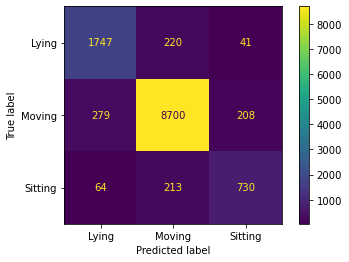

accuracy = 0.9159973774791018
f1-score = [0.85261103 0.94978166 0.73514602]


In [43]:
# training a DescisionTreeClassifier
dtc_model = DecisionTreeClassifier(max_depth = 18).fit(x_train, y_train)
dtc_preds = dtc_model.predict(x_test)

# accuracy score 
accuracy = dtc_model.score(x_test, y_test)
 
# creating a confusion matrix
cm = confusion_matrix(y_test, dtc_preds, labels=dtc_model.classes_)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc_model.classes_)
cmp.plot()
plt.show()

print(f'accuracy = {accuracy}') # etc_model(20)=0.815 // etc_model(9)=0.811 // skb_model(14)=0.803
print(f'f1-score = {f1_score(y_test, dtc_preds, average=None)}')

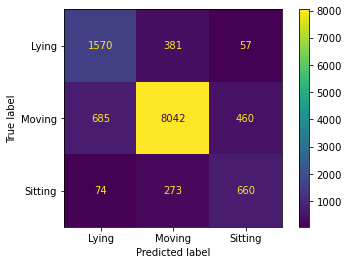

accuracy = 0.8418292083265039
f1-score = [0.72400277 0.89940167 0.6043956 ]


In [48]:
# support vector classifier 
svc_model = SVC(kernel = 'linear', C = 1).fit(x_train, y_train)
svc_preds = svc_model.predict(x_test)
 
# model accuracy for x_test 
accuracy = svc_model.score(x_test, y_test)
 
# creating a confusion matrix
cm = confusion_matrix(y_test, svc_preds, labels=svc_model.classes_)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc_model.classes_)
cmp.plot()
plt.show()

print(f'accuracy = {accuracy}') # etc_model(20) = 0.843 // etc_model(9)=0.817 // skb_model(14)=0.838
print(f'f1-score = {f1_score(y_test, svc_preds, average=None)}')

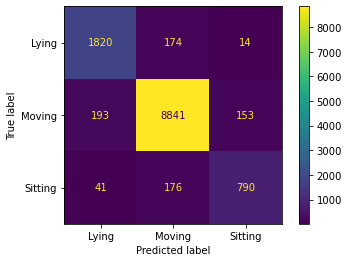

accuracy = 0.938452712670054
f1-score = [0.89611029 0.96212863 0.80448065]


In [49]:
# k nearest neighbours
knn_model = KNeighborsClassifier(n_neighbors = 7).fit(x_train, y_train)
knn_preds = knn_model.predict(x_test) 

# accuracy on x_test
accuracy = knn_model.score(x_test, y_test)
 
# creating a confusion matrix
cm = confusion_matrix(y_test, knn_preds, labels=knn_model.classes_)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_model.classes_)
cmp.plot()
plt.show()

print(f'accuracy = {accuracy}') # etc_model(20) = 0.959 // etc_model(9)=0.946 // skb_model(14)=0.938
print(f'f1-score = {f1_score(y_test, knn_preds, average=None)}')

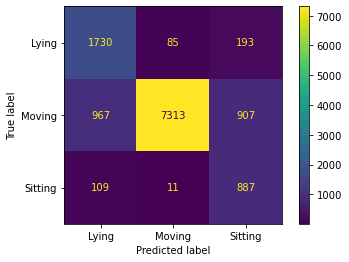

accuracy = 0.8138010162268481
f1-score = [0.71873702 0.8812967  0.59251837]


In [52]:
# naive bayes (gaussian)
gnb_model = GaussianNB().fit(x_train, y_train)
gnb_preds = gnb_model.predict(x_test)
 
# accuracy on x_test
accuracy = gnb_model.score(x_test, y_test)
 
# creating a confusion matrix
cm = confusion_matrix(y_test, gnb_preds, labels=gnb_model.classes_)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc_model.classes_)
cmp.plot()
plt.show()

print(f'accuracy = {accuracy}') # etc_model(20) = 0.803 // etc_model(9)=0.799 // skb_model(14)=0.820
print(f'f1-score = {f1_score(y_test, gnb_preds, average=None)}')

# model evaluation 

* confusion matrix heatmaps again clearly demonstrate the class imbalance - sitting, lying and moving samples were not equally present in the dataset.
* since there were far more dynamic behaviours, the figures for for moving class predictions are comparatively greater 

# leave one (dog) out cross-validation 
* abrogates subject bias 

In [29]:
# groups = df['DogID_Mean'].values
# logo = LeaveOneGroupOut()
# logo.get_n_splits(x_20, y, groups=groups) # verify that there is a split for each dog (total 45) 

# for train_ind, test_ind in logo.split(x_20, y, groups=groups):
#     x_20_train = x_20.iloc[train_ind]
#     x_20_test = x_20.iloc[test_ind]
#     y_train = y.iloc[train_ind]
#     y_test = y.iloc[test_ind]

# to do 
* LOGO CV 
* time algorithms to see which is fastest? infer least computational load and thus suitable for low-power embedded wearable? 